In [27]:
# Set the desired DPI
desired_dpi = 300

In [28]:
import pandas as pd

hot_water_data = pd.read_csv('../data/water/heitavatnsnotkun_a_hofudborgarsvaedinu_heild.csv', sep=';', encoding='utf-8')
cold_water_data = pd.read_csv('../data/water/kaldavatnsnotkun_a_hofudborgarsvaedinu_heild.csv', sep=';', encoding='utf-8')
weather_data = pd.read_csv('../data/yearly-weather-reykjavik.csv', sep='\t', encoding='utf-8', skiprows=1)
# rename columns

hot_water_data = hot_water_data.rename(columns={'Ár': 'year', 'Mannfjöldi á orkuveitusvæði hitaveitu': 'hot_water_population', 'Orkusala hita (millj. m3)': 'hot_water_usage', 'Notkun heits vatns á íbúa  (m3/íbúa)': 'hot_water_usage_per_capita', 'Heitavatnsmælar (fjöldi)': 'hot_water_pumps'})

cold_water_data = cold_water_data.rename(columns={'Ár': 'year', 'Íbúar á vatnsveitusvæði': 'cold_water_population', 'Framleiðsla á köldu vatni, millj.m3': 'cold_water_usage', 'Kaldavatnsmælar': 'cold_water_pumps'})

weather_data = weather_data.rename(columns={' ár': 'year', '  t':'average_temperature', '  tx':'average_high_temperature', '  txx': 'max_temperature', '  tn':'average_low_temperature', ' tnn':'min_temperature', ' rh':'average_precipitation', ' r': 'total_rainfall', ' rx': 'max_rainfall', ' rn': 'total_snowfall', ' p': 'average_air_pressure', ' n':'average_cloud_cover',' nh': 'average_cloud_cover_in_eights', ' f': 'average_wind_speed', 'sun':'average_sunshine_hours'})
weather_data = weather_data.drop(['stöð','txxD1','tnnD1', 'rxD1'], axis=1)

water_data = pd.merge(hot_water_data, cold_water_data, on='year')

# Merge average weather temperature
water_data = pd.merge(water_data, weather_data, on='year')

water_data.head()

,year,hot_water_population,hot_water_usage,hot_water_usage_per_capita,hot_water_pumps,cold_water_population,cold_water_usage,cold_water_pumps,average_temperature,average_high_temperature,max_temperature,average_low_temperature,min_temperature,average_precipitation,total_rainfall,max_rainfall,average_air_pressure,average_cloud_cover,average_sunshine_hours,average_wind_speed
0,1999,160862,56.0,348,NaN,109795,20.5,1560,4.5,7.5,18.9,2.1,-11.6,78.0,787.6,27.8,1003.7,5.8,1268.5,5.5
1,2000,164106,60.6,369,37299.0,111342,21.9,1598,4.5,7.5,18.6,2.1,-11.8,77.0,800.0,47.8,1005.4,5.6,1391.4,4.8
2,2001,166917,62.0,371,43221.0,118348,22.2,1709,5.2,8.3,17.2,2.6,-13.5,78.0,791.9,25.7,1007.8,5.8,1389.1,4.3
3,2002,176976,64.2,363,43893.0,118068,24.1,2024,5.4,8.3,22.4,3.1,-10.8,77.0,916.4,24.6,1004.2,5.7,1366.4,4.3
4,2003,179085,60.0,335,44401.0,118975,24.0,2040,6.1,8.8,20.0,3.7,-11.3,78.0,977.3,19.8,1005.6,6.0,1307.8,4.2


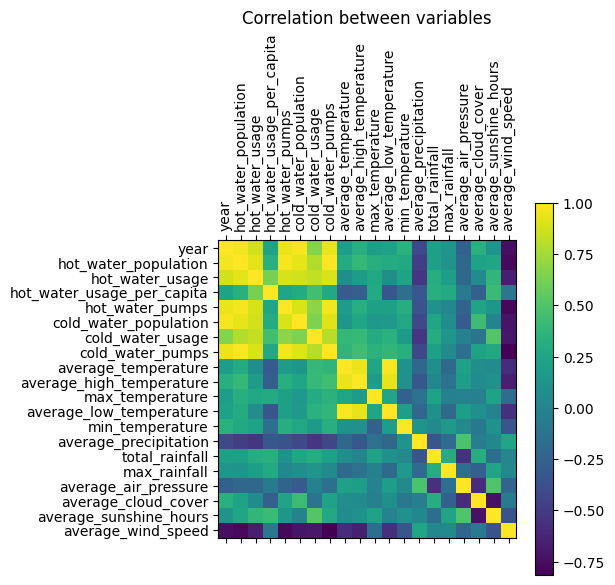

In [29]:
import matplotlib.pyplot as plt

corr = water_data.corr()

plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title('Correlation between variables')
plt.savefig('./figures/correlation.png', dpi=desired_dpi, bbox_inches='tight')

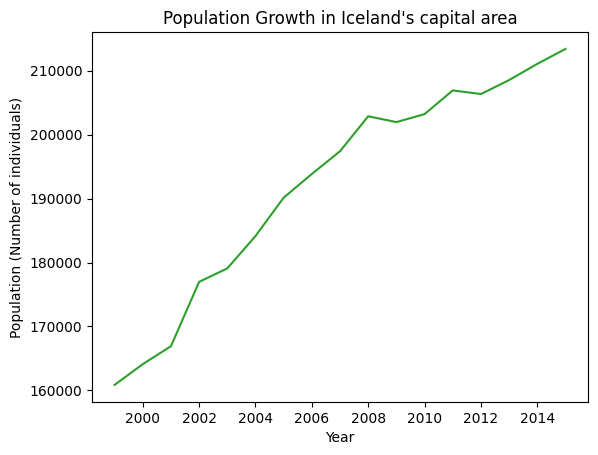

In [30]:
import matplotlib.pyplot as plt

year = water_data['year'] 
hot_water_population = water_data['hot_water_population']

plt.plot(year, hot_water_population, color='tab:green')
plt.xlabel('Year')
plt.ylabel('Population (Number of individuals)')
plt.title("Population Growth in Iceland's capital area")

plt.savefig("./figures/population-growth.png", dpi=desired_dpi)

In [31]:
# predict hot water population
from xgboost import XGBRegressor
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

year = water_data['year'].values.reshape(-1, 1)
hot_water_population = water_data['hot_water_population'].values.reshape(-1, 1)

# normalize data
scaler_year = MinMaxScaler()
scaler_hot_water_population = MinMaxScaler()

year = scaler_year.fit_transform(year)
hot_water_population = scaler_hot_water_population.fit_transform(hot_water_population)

X_train, X_test_model_population, y_train_model_population, y_test_model_population = train_test_split(year, hot_water_population, test_size=0.2, random_state=0)

# train model
model_hot_water_population = XGBRegressor()
model_hot_water_population.fit(X_train, y_train_model_population)
model_hot_water_population.score(X_test_model_population, y_test_model_population)

0.9601259613590487

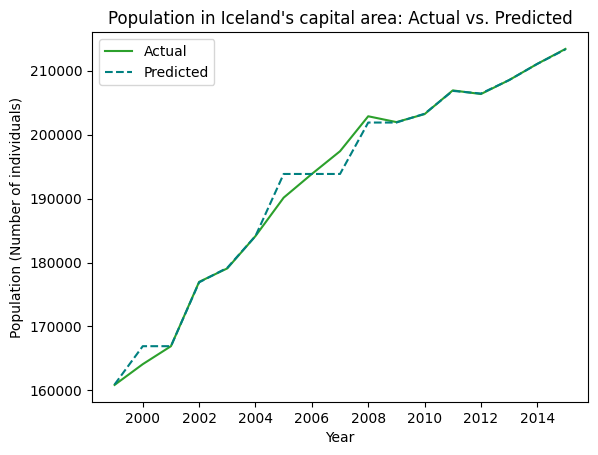

In [32]:
import matplotlib.pyplot as plt

model_pred = model_hot_water_population.predict(year).reshape(-1, 1)
# unnormalize data
model_pred = scaler_hot_water_population.inverse_transform(model_pred)
model_year = scaler_year.inverse_transform(year)
true_year = scaler_year.inverse_transform(year)
true_hot_water_population = scaler_hot_water_population.inverse_transform(hot_water_population)

plt.plot(true_year, true_hot_water_population, color='tab:green', label='Actual')
plt.plot(model_year, model_pred, linestyle='dashed', color='teal', label='Predicted')
plt.xlabel('Year')
plt.ylabel('Population (Number of individuals)')
plt.legend()
plt.title("Population in Iceland's capital area: Actual vs. Predicted")

plt.savefig("./figures/population-hot-water-area-actual-vs-predicted.png", dpi=desired_dpi)

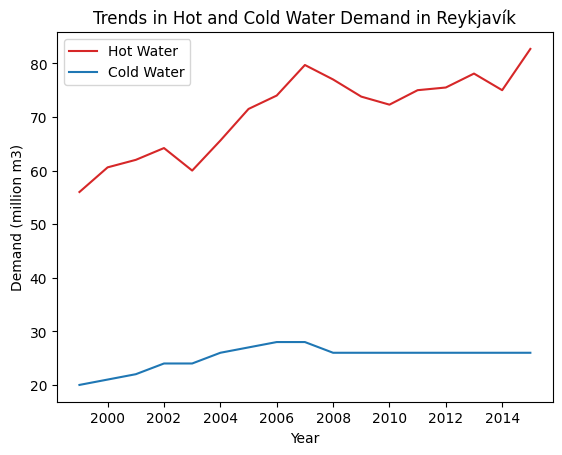

In [33]:
import matplotlib.pyplot as plt

# Plotting hot water data
year = water_data['year']
# in m3 per capita
amount_hot = water_data['hot_water_usage']

plt.plot(year, amount_hot, label='Hot Water', color='tab:red')

# Plotting cold water data

# in m3 per capita
amount_cold = water_data['cold_water_usage'].astype(int)

plt.plot(year, amount_cold, label='Cold Water', color='tab:blue')

plt.title('Trends in Hot and Cold Water Demand in Reykjavík')
plt.ylabel('Demand (million m3)')
plt.xlabel('Year')
plt.legend()

# plt.show()
plt.savefig("./figures/trends-in-hot-and-cold-water-demand.png", dpi=desired_dpi)



In [34]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression for hot water
X_hot = water_data['year'].values.reshape(-1, 1)

y_hot = water_data['hot_water_usage'].values.reshape(-1, 1)

# Normalize data
scaler_hot_x = StandardScaler()
scaler_hot_y = StandardScaler()
X_hot_scaled = scaler_hot_x.fit_transform(X_hot)
y_hot_scaled = scaler_hot_y.fit_transform(y_hot)

X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(X_hot_scaled, y_hot_scaled, test_size=0.2, random_state=0)

regressor_hot = XGBRegressor(n_estimators=1500, learning_rate=5e-2, n_jobs=5)
regressor_hot.fit(X_train_hot, y_train_hot)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=5, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
# Linear regression for cold water
X_cold = water_data['year'].values.reshape(-1, 1)
y_cold = water_data['cold_water_usage'].values.reshape(-1, 1)

# Normalize data
scaler_cold_x = StandardScaler()
scaler_cold_y = StandardScaler()
X_cold_scaled = scaler_cold_x.fit_transform(X_cold)
y_cold_scaled = scaler_cold_y.fit_transform(y_cold)

X_train_cold, X_test_cold, y_train_cold, y_test_cold = train_test_split(X_cold_scaled, y_cold_scaled, test_size=0.2, random_state=0)

regressor_cold = RandomForestRegressor()
regressor_cold.fit(X_train_cold, y_train_cold)

/var/folders/ws/gh0tq52x7ld84fxczqzrkjv80000gn/T/ipykernel_80202/4202497450.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor_cold.fit(X_train_cold, y_train_cold)


RandomForestRegressor()

In [36]:
# validation accuracy
hot_water_population = water_data['hot_water_population'].values.reshape(-1, 1)
validation_accuracy = regressor_hot.score(X_test_hot, y_test_hot), regressor_cold.score(X_test_cold, y_test_cold), model_hot_water_population.score(X_test_model_population, y_test_model_population)
print('Validation accuracy: {}'.format(validation_accuracy))

# mse, rmse, mae
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_hot = regressor_hot.predict(X_test_hot)
y_pred_cold = regressor_cold.predict(X_test_cold)

mse_hot = mean_squared_error(y_test_hot, y_pred_hot)
rmse_hot = np.sqrt(mse_hot)
mae_hot = mean_absolute_error(y_test_hot, y_pred_hot)

mse_cold = mean_squared_error(y_test_cold, y_pred_cold)
rmse_cold = np.sqrt(mse_cold)
mae_cold = mean_absolute_error(y_test_cold, y_pred_cold)

mse_hot_water_population = mean_squared_error(y_test_model_population, model_hot_water_population.predict(X_test_model_population))
rmse_hot_water_population = np.sqrt(mse_hot_water_population)
mae_hot_water_population = mean_absolute_error(y_test_model_population, model_hot_water_population.predict(X_test_model_population))

print('Hot water: mse: {}, rmse: {}, mae: {}'.format(mse_hot, rmse_hot, mae_hot))
print('Cold water: mse: {}, rmse: {}, mae: {}'.format(mse_cold, rmse_cold, mae_cold))
print('Hot water population: mse: {}, rmse: {}, mae: {}'.format(mse_hot_water_population, rmse_hot_water_population, mae_hot_water_population))

Validation accuracy: (0.761957283853581, 0.8967800360565521, 0.9601259613590487)
Hot water: mse: 0.22135078444396647, rmse: 0.47047931351332173, mae: 0.4216726965551486
Cold water: mse: 0.13647619222915222, rmse: 0.36942684286493344, mae: 0.33221408494701343
Hot water population: mse: 0.003190524126571311, rmse: 0.056484724718912374, mae: 0.05258987278290739


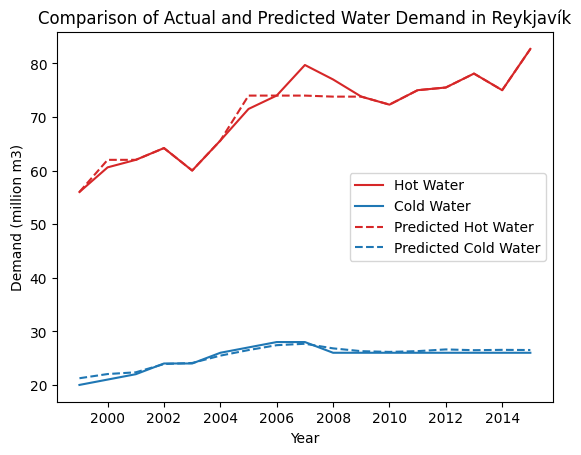

In [37]:
# Predicting hot water usage
hot_model_input = scaler_hot_x.transform(X_hot)
hot_pred = regressor_hot.predict(hot_model_input).reshape(1, -1)
hot_pred = scaler_hot_y.inverse_transform(hot_pred)

# Predicting cold water usage
cold_model_input = scaler_cold_x.transform(X_cold)
cold_pred = regressor_cold.predict(cold_model_input).reshape(1, -1)
cold_pred = scaler_cold_y.inverse_transform(cold_pred)

# Plotting hot water data
year_hot = water_data['year']
# in m3 per capita
amount_hot = water_data['hot_water_usage']

plt.plot(year_hot, amount_hot, label='Hot Water', color='tab:red')

# Plotting cold water data
year_cold = water_data['year']
# in m3 per capita
amount_cold = water_data['cold_water_usage'].astype(int)

plt.plot(year_cold, amount_cold, label='Cold Water', color='tab:blue')

# # Plotting predicted hot water data
plt.plot(year_hot, hot_pred[0], label='Predicted Hot Water', color='tab:red', linestyle='dashed')

# # Plotting predicted cold water data
plt.plot(year_cold, cold_pred[0], label='Predicted Cold Water', color='tab:blue', linestyle='dashed')

plt.title('Comparison of Actual and Predicted Water Demand in Reykjavík')
plt.ylabel('Demand (million m3)')
plt.xlabel('Year')
plt.legend()

plt.savefig("./figures/comparision-of-actual-and-predicted-water-demand.png", dpi=desired_dpi)

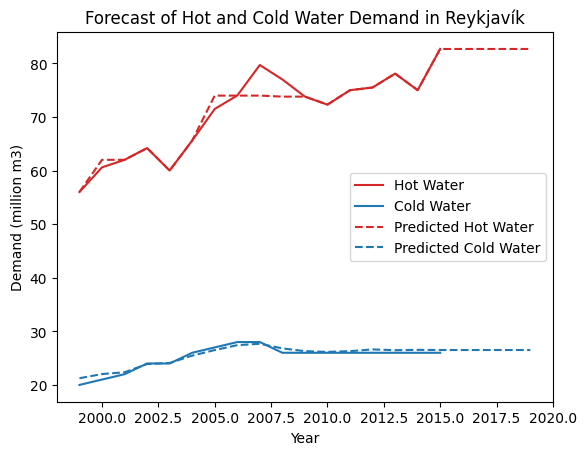

In [38]:
# add 10 years to the data
hot_input = X_hot
cold_input = X_cold

forecast_years = 5

for i in range(X_hot.max() + 1, X_hot.max() + forecast_years):
    hot_input = np.append(X_hot, [[i]], axis=0)
for i in range(X_cold.max() + 1, X_cold.max() + forecast_years):
    cold_input = np.append(X_cold, [[i]], axis=0)

# Predicting hot water usage
hot_model_input = scaler_hot_x.transform(hot_input)
hot_pred = regressor_hot.predict(hot_model_input).reshape(1, -1)
hot_pred = scaler_hot_y.inverse_transform(hot_pred)

# Predicting cold water usage
cold_model_input = scaler_cold_x.transform(cold_input)
cold_pred = regressor_cold.predict(cold_model_input).reshape(1, -1)
cold_pred = scaler_cold_y.inverse_transform(cold_pred)

# Plotting hot water data
year_hot = water_data['year']
# in m3 per capita
amount_hot = water_data['hot_water_usage']

plt.plot(year_hot, amount_hot, label='Hot Water', color='tab:red')

# Plotting cold water data
year_cold = water_data['year']
# in m3 per capita
amount_cold = water_data['cold_water_usage'].astype(int)

plt.plot(year_cold, amount_cold, label='Cold Water', color='tab:blue')

# # Plotting predicted hot water data
plt.plot(hot_input, hot_pred[0], label='Predicted Hot Water', color='tab:red', linestyle='dashed')

# # Plotting predicted cold water data
plt.plot(cold_input, cold_pred[0], label='Predicted Cold Water', color='tab:blue', linestyle='dashed')

plt.title('Forecast of Hot and Cold Water Demand in Reykjavík')
plt.ylabel('Demand (million m3)')
plt.xlabel('Year')
plt.legend()

plt.savefig("./figures/forecast-of-hot-and-cold-water-demand.png", dpi=desired_dpi)